<a href="https://colab.research.google.com/github/emrullahozkilinc/machine-learning/blob/master/Depression_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, LeakyReLU
from keras.optimizers import Adam
import math


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
conditions = []
for x in range(1,24):
  conditions.append(pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/condition/condition_%s.csv'%(x)))

controls = []
for x in range(1,33):
  controls.append(pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/control/control_%s.csv'%(x)))

scores = pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/scores.csv')

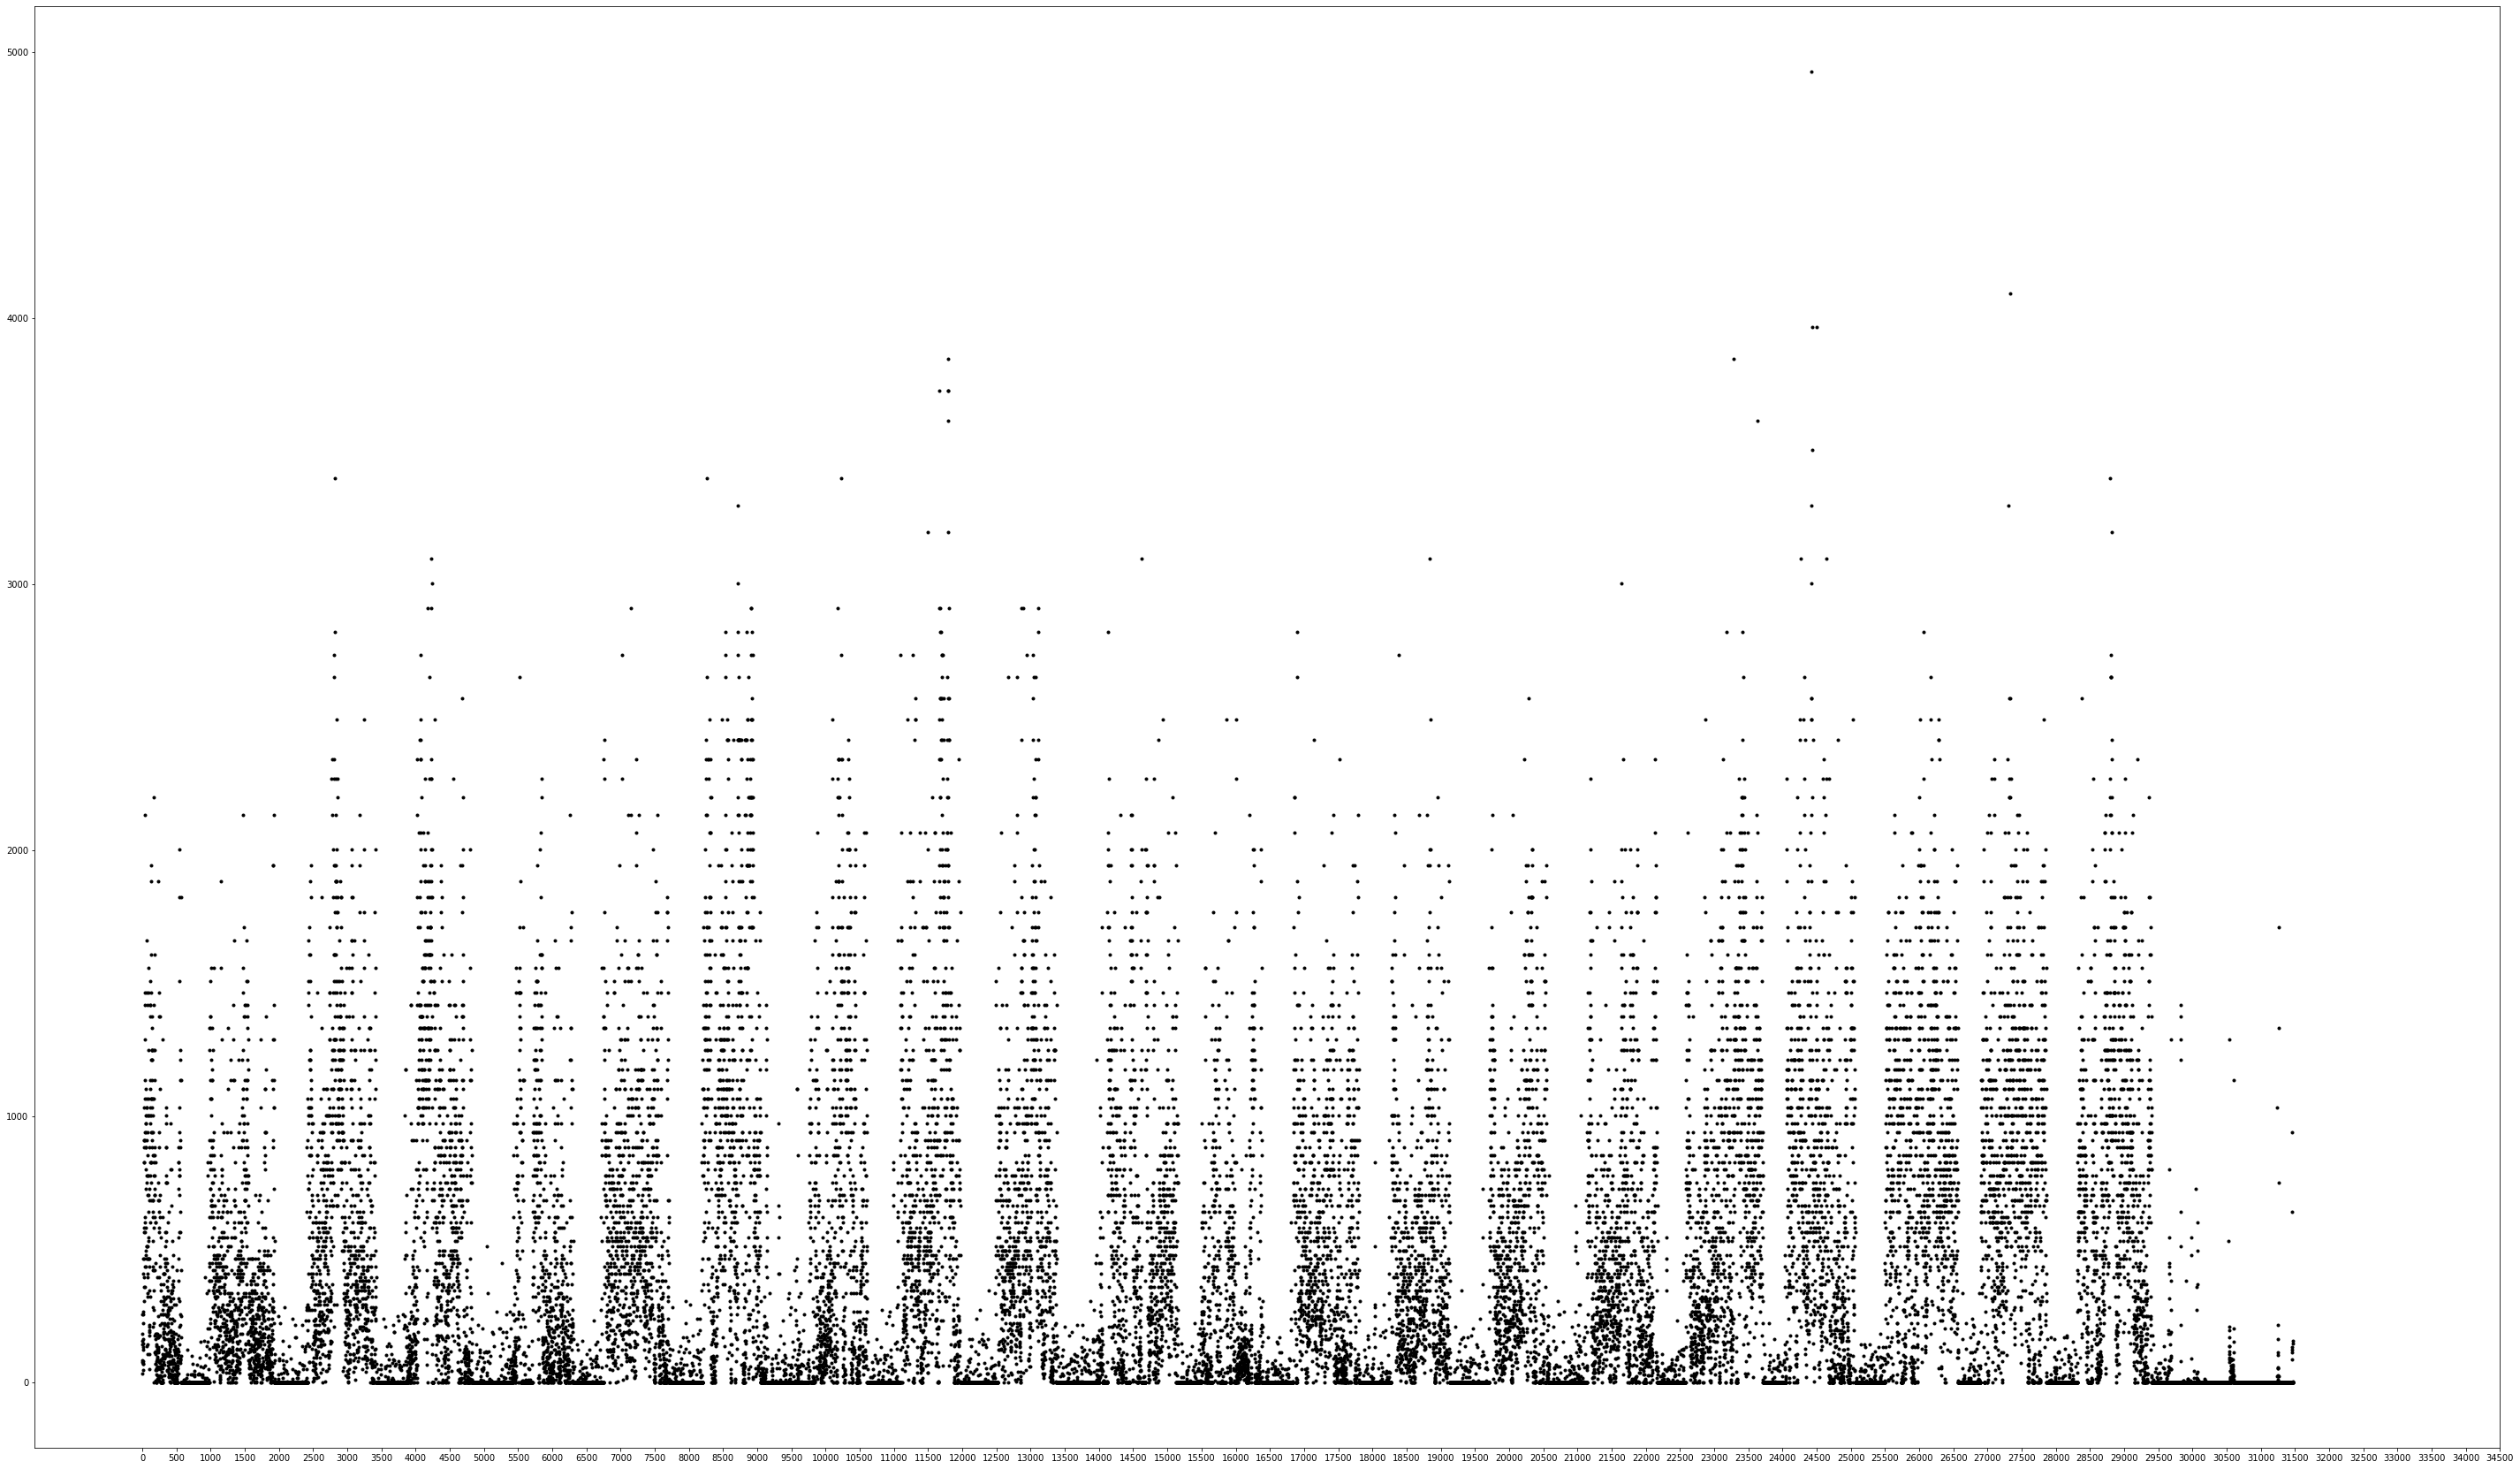

In [4]:
fig,ax = plt.subplots(figsize = (50,30))
controls[1]['activity'].plot(style = 'k.')
ax.set_xticks(range(0,35000,500))

In [5]:
controls[1].loc[controls[1]['activity']<=20].groupby('activity', axis = 0)['activity'].count()

activity
0     11324
3       164
5        80
7        50
8        87
10       69
12       54
13       80
15       63
17       65
18       49
20       58
Name: activity, dtype: int64

<BarContainer object of 55 artists>

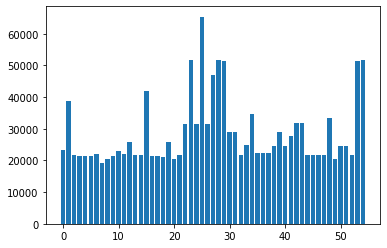

In [6]:
all_sizes = []
for x in conditions:
  all_sizes.append(len(x))

for x in controls:
  all_sizes.append(len(x))

plt.bar(range(len(all_sizes)), all_sizes)

**Outlierların Belirlenmesi ve Temizlenmesi**

In [7]:
for n,x in enumerate(conditions):
  act = x['activity']
  Q1 = act.quantile(0.25)
  Q3 = act.quantile(0.75)
  Iqr = (Q3-Q1)
  print(len(conditions[n]))
  conditions[n] = x[~((x['activity'] < (Q1-Iqr*0.5)) | (x['activity']  > (Q3+Iqr*0.5)))]
  print(len(conditions[n]))


23244
18757
38926
30736
21648
17863
21556
17575
21493
17318
21433
17531
22175
17710
19299
15512
20318
16633
21555
18081
22990
18127
22147
17971
25910
21484
21646
17013
21829
17557
41847
32468
21531
17504
21347
17530
21231
17116
25847
19932
20487
15750
21772
18295
31485
25560


**Verilerin 400'ün katına getirilmesi için fazlalıkların çıkarılması**

In [8]:
conditions_shapes = [x.shape[0] for x in conditions]
split_size = 400
reshaped_conditions = []
for n,x in enumerate(conditions_shapes):
  to_split_n = (conditions_shapes[n]%split_size)
  reshaped_conditions.append(conditions[n].iloc[:-to_split_n,:])

**Her verinin 400 timestamp'e eşitlenmesi**

In [9]:
resized_data = {}
for x,y in enumerate(reshaped_conditions):
  new_shape = int(y.shape[0]/split_size)
  dfs = []
  for z in range(1,split_size+1):
    mean = y[new_shape*(z-1):new_shape*z]['activity'].mean()
    dfs.append(mean)
  resized_data[x] = np.array(dfs)

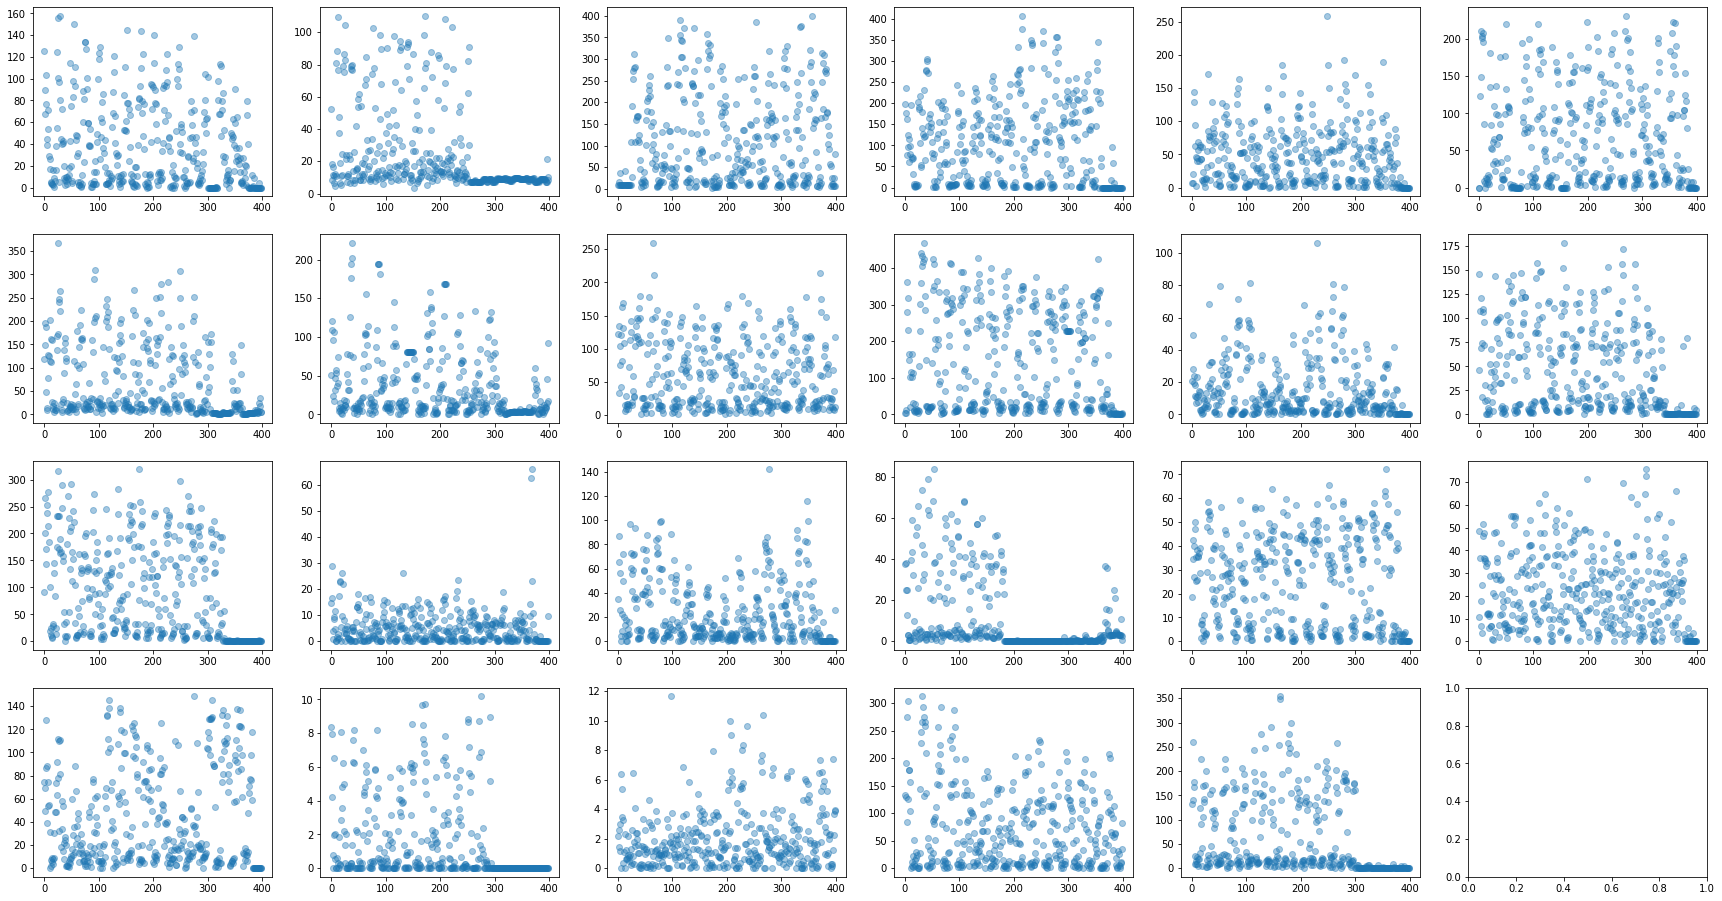

In [10]:
row_size = math.ceil(len(resized_data)/6)
col_size = math.ceil(len(resized_data)/4)

fig, ax = plt.subplots(row_size, col_size, figsize = (30,16))
ax = ax.ravel()

for x in range(len(conditions)):
  ax[x].scatter(range(split_size), resized_data[x], marker = 'o', alpha = 0.4)

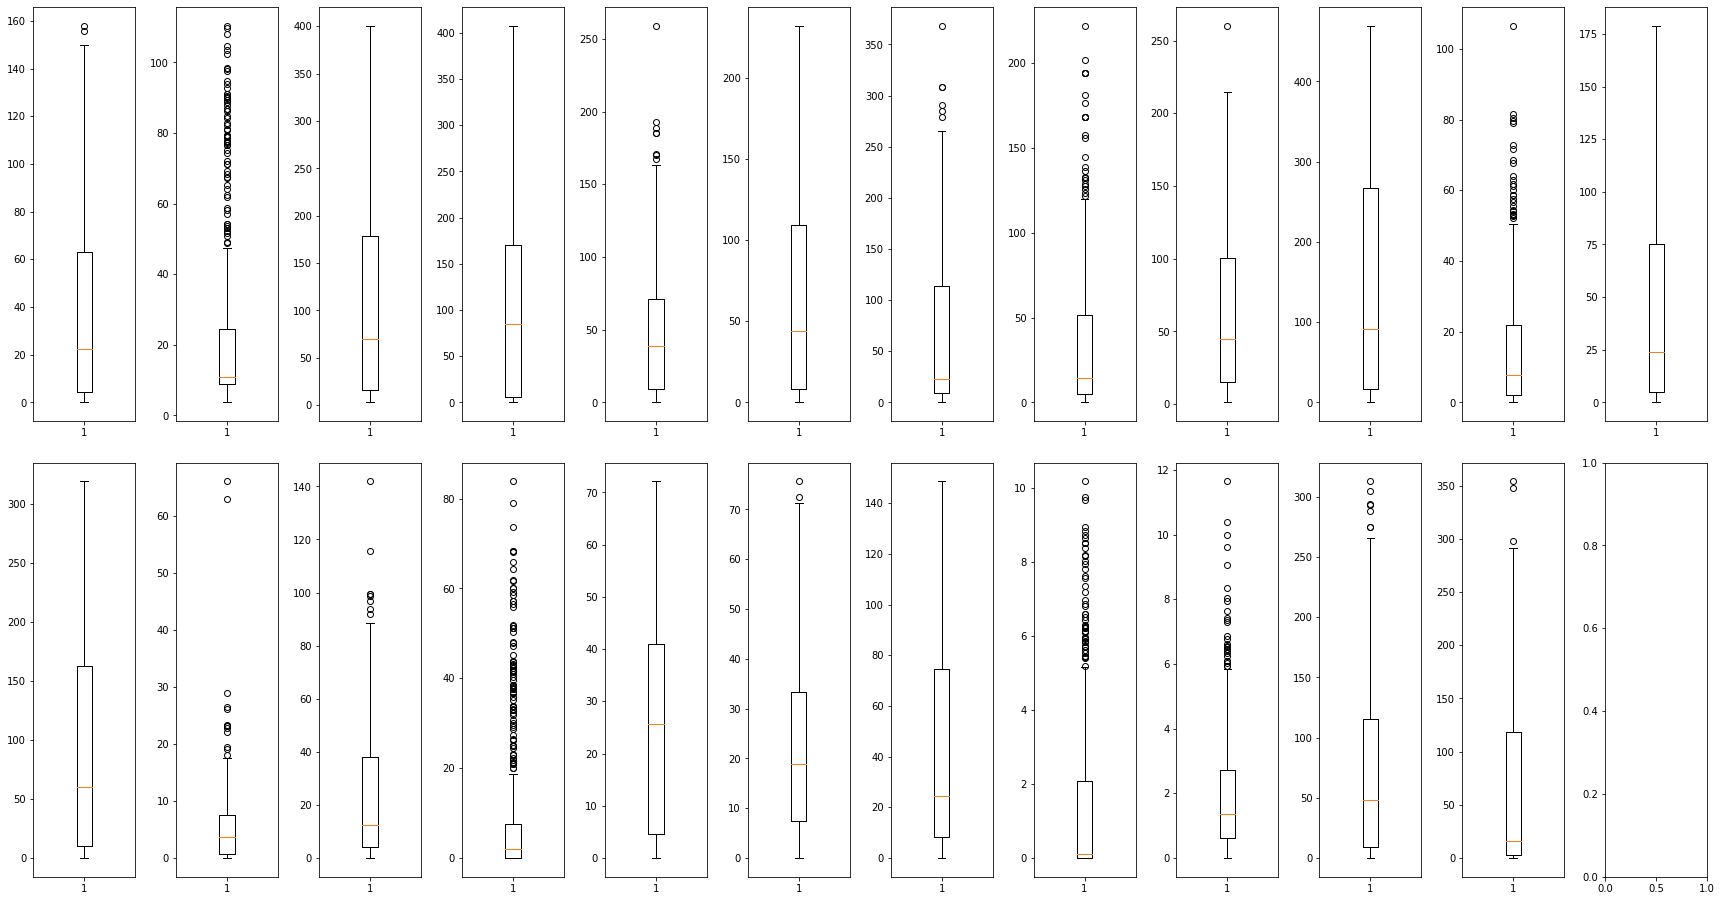

In [11]:
row_size = 2
col_size = math.ceil(len(resized_data)/2)

fig, ax = plt.subplots(row_size, col_size, figsize = (30,16))
fig.subplots_adjust(hspace = .1, wspace=.4)
ax = ax.ravel()

for x in range(len(resized_data)):
  ax[x].boxplot(resized_data[x])

In [12]:
scaler = StandardScaler()

scaled_data = []
for x in list(resized_data.values()):
  x = np.array(x).reshape(-1,1)
  scaled_data.append(scaler.fit_transform(x))

**Verilerin bölünmesi**

In [19]:
validation_size = 1
test_size = 2
train_size = len(resized_data)-validation_size-test_size

resized_data_ls = scaled_data

X_train = np.array(resized_data_ls[:][:train_size])
X_val = np.array(resized_data_ls[train_size+validation_size-1])
X_test = np.array(resized_data_ls[-test_size:])

y = np.array(scores['madrs2']-scores['madrs1'])

y_train = y[:train_size].reshape(train_size,-1)
y_val = y[train_size+validation_size-1].reshape( validation_size, -1)
y_test = y[train_size+validation_size:train_size+validation_size+test_size].reshape(test_size, -1)


In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[1], X_val.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(75, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

opt = Adam(learning_rate=0.0005)

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit( X_train, y_train, batch_size=50, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
1/1 [==============================] - 8s 8s/step - loss: 0.3065 - val_loss: 1.4278e-04
Epoch 2/40
1/1 [==============================] - 1s 750ms/step - loss: 0.3017 - val_loss: 9.4694e-04
Epoch 3/40
1/1 [==============================] - 1s 754ms/step - loss: 0.2969 - val_loss: 0.0026
Epoch 4/40
1/1 [==============================] - 1s 753ms/step - loss: 0.2851 - val_loss: 0.0055
Epoch 5/40
1/1 [==============================] - 1s 728ms/step - loss: 0.2796 - val_loss: 0.0100
Epoch 6/40
1/1 [==============================] - 1s 738ms/step - loss: 0.2731 - val_loss: 0.0166
Epoch 7/40
1/1 [==============================] - 1s 742ms/step - loss: 0.2692 - val_loss: 0.0267
Epoch 8/40
1/1 [==============================] - 1s 731ms/step - loss: 0.2677 - val_loss: 0.0403
Epoch 9/40
1/1 [==============================] - 1s 734ms/step - loss: 0.2659 - val_loss: 0.0520
Epoch 10/40
1/1 [==============================] - 1s 727ms/step - loss: 0.2720 - val_loss: 0.0563
Epoch 11/40
1/

In [34]:
model.predict(X_train[15].reshape(1,400,1))

array([[0.5755931]], dtype=float32)